<center>
<h1> Task 2: Fraud Detection</h2>
</center>

# About Dataset
#### Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

#### Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

/home/student/Desktop/Wonderful/New Test/Fraud_detection/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/student/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


## Import necessary libraries and overview of dataset

Import a few libraries that will help us process, analyze, and visualize the data.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
file_path = f"{path}/creditcard.csv"

data = pd.read_csv(file_path)
data.head()
data.to_csv('creditcard_dataset.csv', index=False)

In [6]:
credit_card_data = data.copy()
credit_card_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We have different attributes, we have Time, which can be in minutes or seconds, we have other attributes from V1 to V28 which are the results of PCA we have the amount in EURo because the dataset was collected from Eropean country , we have also the the class variables we have..

check the shape of credit card dataset

In [7]:
credit_card_data.shape

(284807, 31)

The shape of dataset shows that the datset contains 284,807 rows and 31 columns and each row is analyzed to identify whether it corresponds to a fraudulent transaction.

In [8]:
value_counts = credit_card_data['Class'].value_counts()
value_counts

Class
0    284315
1       492
Name: count, dtype: int64

In the transactions that occurred in two days,  we have 492 frauds out of 284,807 transactions. that show that the good transaction are 284315.

In [9]:
credit_card_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

A we can see our dataset has different attributes. Time, Amount and Class , and othe attribute obtained after PCA was applied.

Summary statistics of credit_card_dataaset

In [10]:
credit_card_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


minimum amount spent are 0.0 while the maximum amount are 25691.160000 and for time  minimum is 0.00 and maximum is  172792.0 there is a really big difference so we can  need to do some more transformation such as Log Transformation and Standard Scaler. but for other attributes all the value are in resonable range when we compare their minimumvalue and maximum value.

In [11]:
count_zero_amount = credit_card_data[credit_card_data['Amount'] == 0 ].shape[0]

print(f"Number of rows where the 'Amount' is 0: {count_zero_amount}")

Number of rows where the 'Amount' is 0: 1825


In [12]:
count_zero_amount = credit_card_data[(credit_card_data['Amount'] == 0) & (credit_card_data['Class'] == 1)].shape[0]

print(f"where both the 'Amount' and 'Class' columns are equal to zero.: {count_zero_amount}")

where both the 'Amount' and 'Class' columns are equal to zero.: 27


We can not conclude that the transaction when the 'amount' is equal to 0.0 is fraud because most of values are in the "Class" with value 0

In [13]:
info_df = pd.DataFrame({
    'Data Type': credit_card_data.dtypes,
    'Non-Null Count': credit_card_data.notnull().sum(),
    'Unique Value Count': credit_card_data.nunique()
})

info_df

,Data Type,Non-Null Count,Unique Value Count
Time,float64,284807,124592
V1,float64,284807,275663
V2,float64,284807,275663
V3,float64,284807,275663
V4,float64,284807,275663
V5,float64,284807,275663
V6,float64,284807,275663
V7,float64,284807,275663
V8,float64,284807,275663
V9,float64,284807,275663


We can see all the count and the datatype of values. We can see that we have 31 attributes one is output and the remained one are the input. And there is there is no null values in our dataset.

# Explaratory data analysis

We  begin by exploring 'class'  attributes.

## Histogram

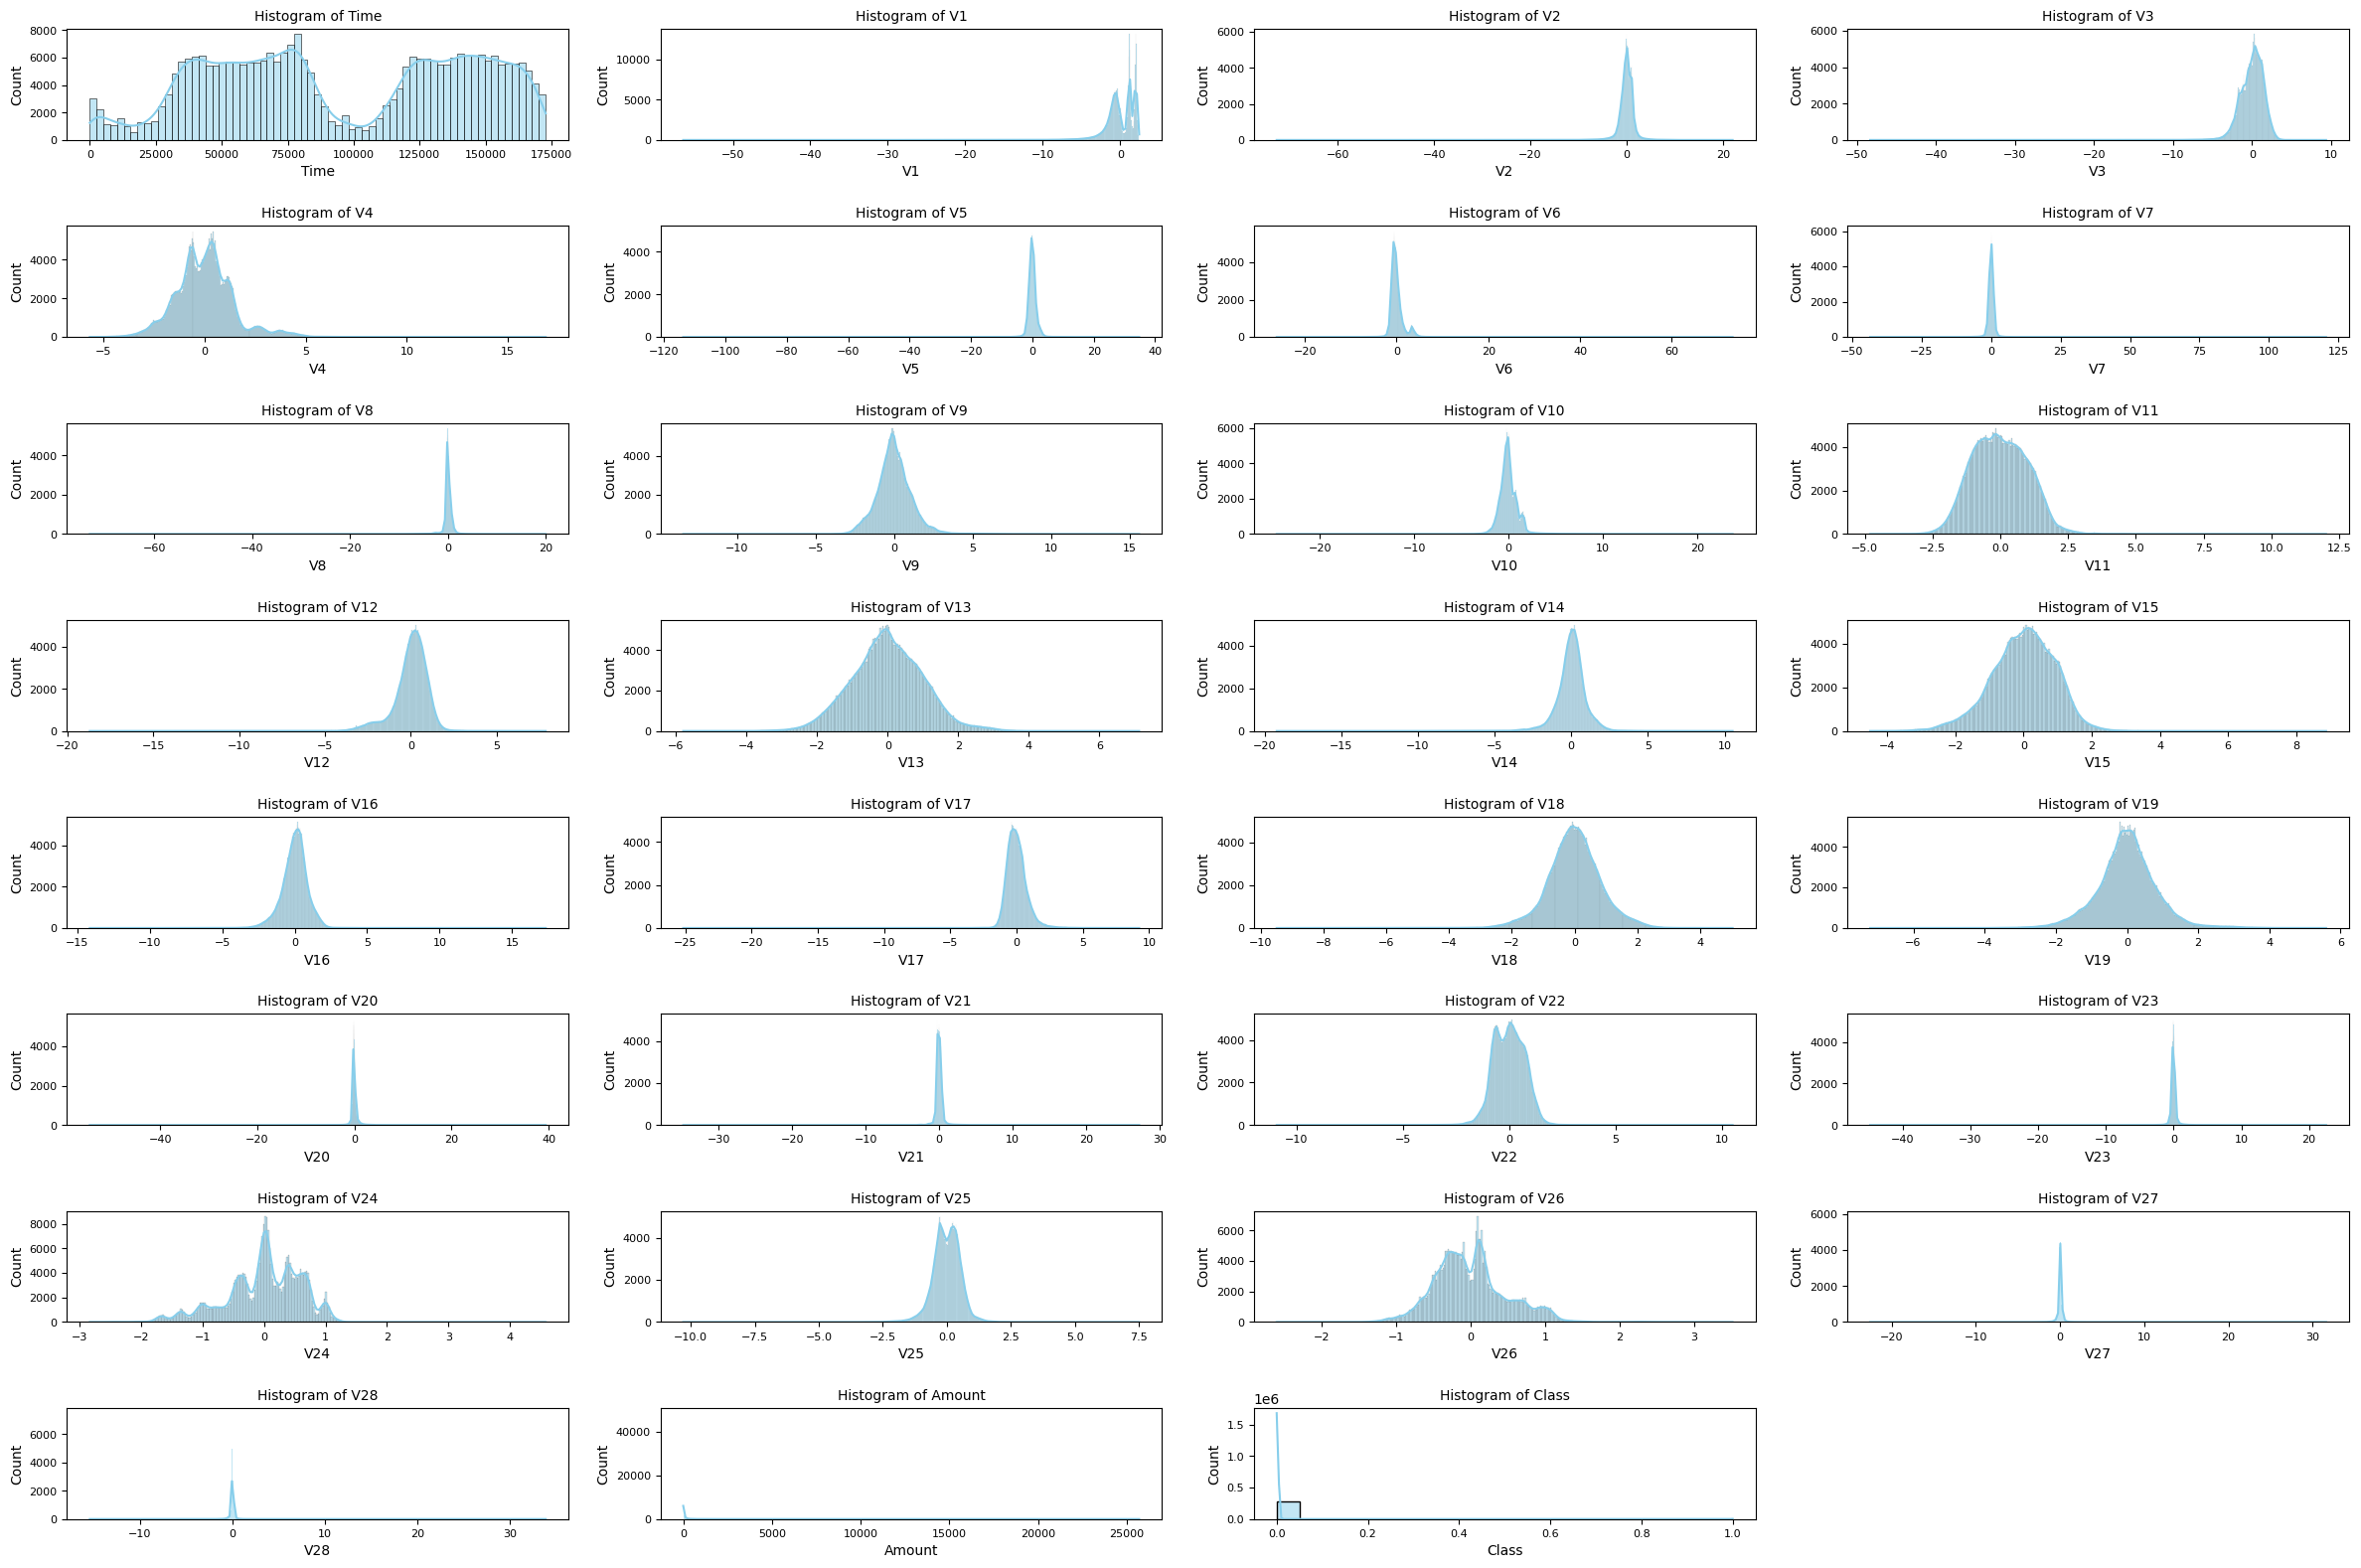

In [14]:
# Plot histograms for all columns

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots with better spacing and size
fig, ax = plt.subplots(ncols=4, nrows=8, figsize=(24, 16))
ax = ax.flatten()  # Flatten the array of axes for easy indexing

# Loop through each column and create a histogram
for index, col in enumerate(credit_card_data.columns):
    sns.histplot(data=credit_card_data, x=col, ax=ax[index], kde=True, color='skyblue')  # Add kde=True for density curve
    ax[index].set_title(f'Histogram of {col}', fontsize=10)
    ax[index].tick_params(axis='x', labelsize=8)
    ax[index].tick_params(axis='y', labelsize=8)

# Remove unused subplots
for i in range(len(credit_card_data.columns), len(ax)):
    fig.delaxes(ax[i])

# Adjust layout for better readability
plt.tight_layout(pad=1.5, w_pad=1.5, h_pad=2.0)

# Show the plot
plt.show()


Most of value are normally distributed accross all attributes.

 We need to see the distribution of Time feature using Histgram to understand how transactions are distributed over the recorded time period and compare the density and spread of fraudulent vs. non-fraudulent transactions over time.

In [15]:
credit_card_data['Time'].unique()

array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 1.72787e+05,
       1.72788e+05, 1.72792e+05], shape=(124592,))

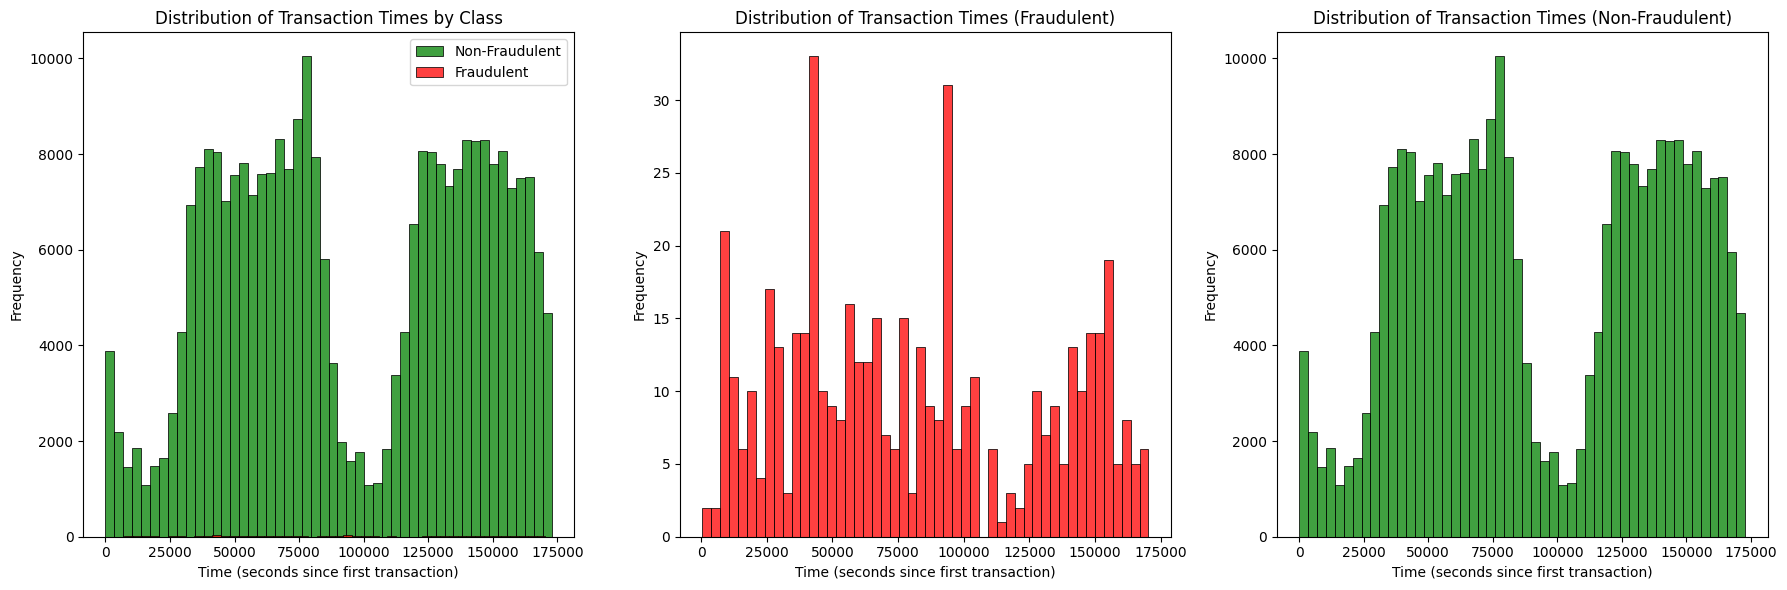

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with multiple subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Combined plot for both fraudulent and non-fraudulent transactions
sns.histplot(credit_card_data[credit_card_data['Class'] == 0]['Time'], bins=50, color='green', label='Non-Fraudulent', kde=False, ax=axes[0])
sns.histplot(credit_card_data[credit_card_data['Class'] == 1]['Time'], bins=50, color='red', label='Fraudulent', kde=False, ax=axes[0])
axes[0].set_title('Distribution of Transaction Times by Class')
axes[0].set_xlabel('Time (seconds since first transaction)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot for fraudulent transactions
sns.histplot(credit_card_data[credit_card_data['Class'] == 1]['Time'], bins=50, color='red', kde=False, ax=axes[1])
axes[1].set_title('Distribution of Transaction Times (Fraudulent)')
axes[1].set_xlabel('Time (seconds since first transaction)')
axes[1].set_ylabel('Frequency')

# Plot for non-fraudulent transactions
sns.histplot(credit_card_data[credit_card_data['Class'] == 0]['Time'], bins=50, color='green', kde=False, ax=axes[2])
axes[2].set_title('Distribution of Transaction Times (Non-Fraudulent)')
axes[2].set_xlabel('Time (seconds since first transaction)')
axes[2].set_ylabel('Frequency')



# Show the plots
plt.tight_layout()
plt.show()


The histogram show that the  fraudulent Transaction are too few compared to Non fraudulent transaction.  if you see histogram which contain both the one with Non- frauderent dominate, the one without fraudrent are not even visible.

Analyze the relationship between time and fraud by plotting histograms for fraudulent and non-fraudulent transactions separately.

The goal histogram for the Amount feature in the credit_card_data dataset is to analyze the distribution of transaction amounts. To be able to identify patterns or anomalies in transaction values, which can be indicative of fraudulent behavior.

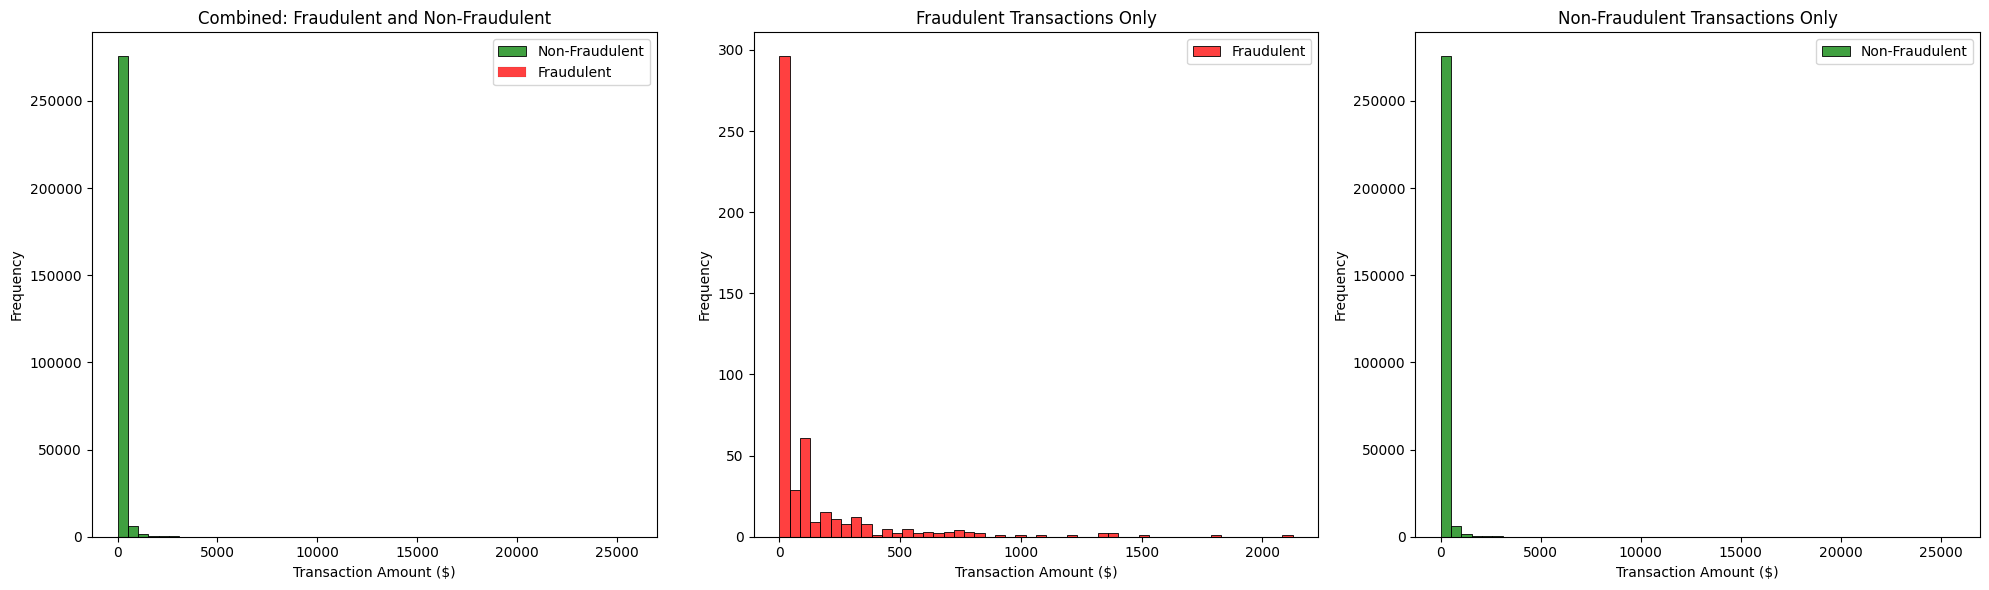

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with multiple subplots for all three cases
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Combined histogram for fraudulent and non-fraudulent transactions
sns.histplot(credit_card_data[credit_card_data['Class'] == 0]['Amount'], bins=50, color='green', label='Non-Fraudulent', kde=False, ax=axes[0])
sns.histplot(credit_card_data[credit_card_data['Class'] == 1]['Amount'], bins=50, color='red', label='Fraudulent', kde=False, ax=axes[0])
axes[0].set_title('Combined: Fraudulent and Non-Fraudulent')
axes[0].set_xlabel('Transaction Amount ($)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Histogram for fraudulent transactions only
sns.histplot(credit_card_data[credit_card_data['Class'] == 1]['Amount'], bins=50, color='red', label='Fraudulent', kde=False, ax=axes[1])
axes[1].set_title('Fraudulent Transactions Only')
axes[1].set_xlabel('Transaction Amount ($)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Histogram for non-fraudulent transactions only
sns.histplot(credit_card_data[credit_card_data['Class'] == 0]['Amount'], bins=50, color='green', label='Non-Fraudulent', kde=False, ax=axes[2])
axes[2].set_title('Non-Fraudulent Transactions Only')
axes[2].set_xlabel('Transaction Amount ($)')
axes[2].set_ylabel('Frequency')
axes[2].legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In order to gain better understanding of the dataset's imbalance we need to analyse Class distribution, we used Hostogram and Pie Chart.

Transaction amounts have a highly skewed distribution, with many small transactions and a few very large ones. we used a logarithmic scale to make the histogram easier to interpret.

### Log Transformation on "Amount" Columns

In [18]:
# Check columns we have
credit_card_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [19]:
import numpy as np

# Create a new column 'Log_Amount' with a log transformation
credit_card_data['Log_Amount'] = np.log1p(credit_card_data['Amount'])  


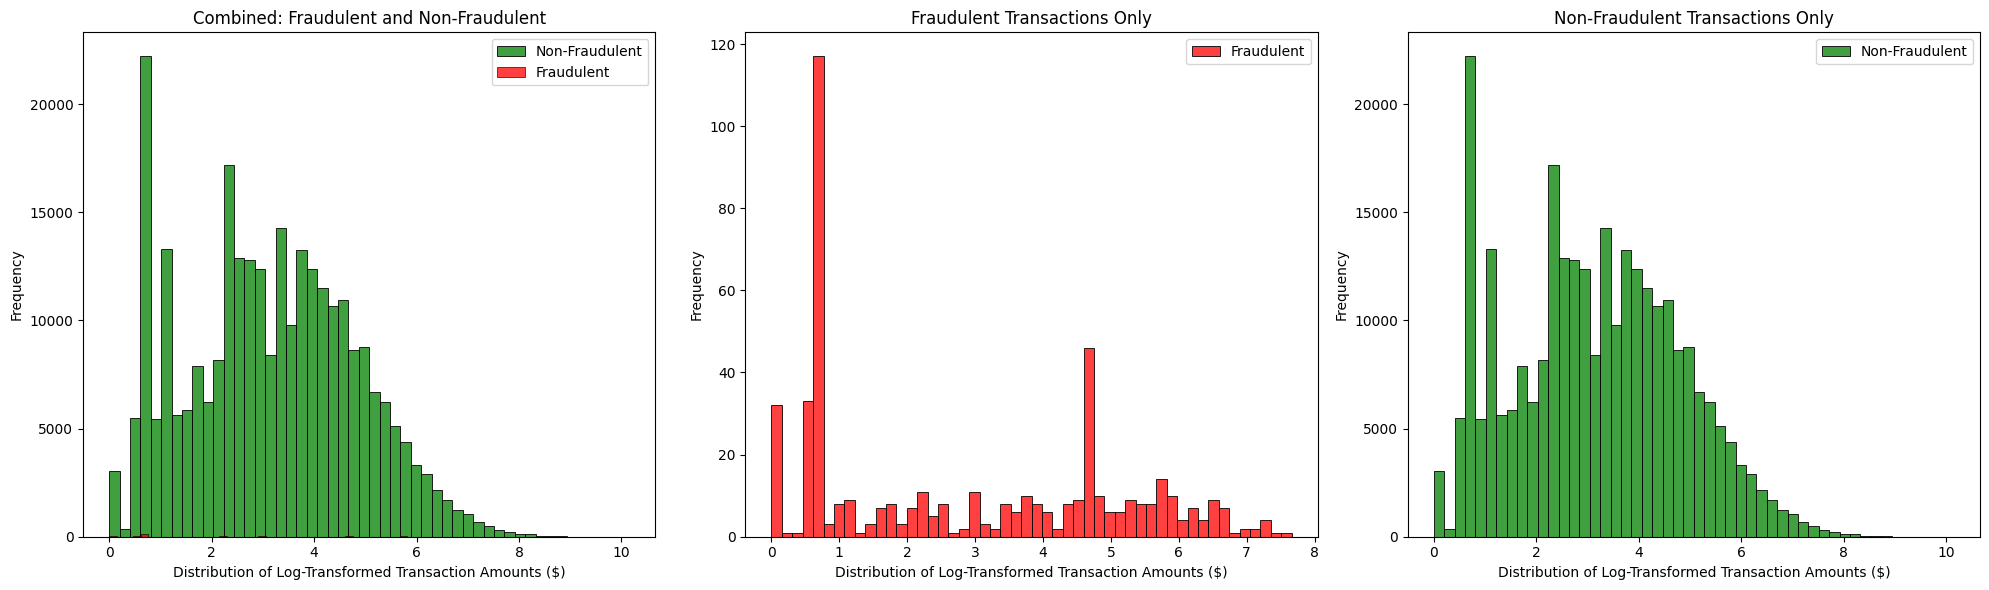

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with multiple subplots for all three cases
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Combined histogram for fraudulent and non-fraudulent transactions
sns.histplot(credit_card_data[credit_card_data['Class'] == 0]['Log_Amount'], bins=50, color='green', label='Non-Fraudulent', kde=False, ax=axes[0])
sns.histplot(credit_card_data[credit_card_data['Class'] == 1]['Log_Amount'], bins=50, color='red', label='Fraudulent', kde=False, ax=axes[0])
axes[0].set_title('Combined: Fraudulent and Non-Fraudulent')
axes[0].set_xlabel('Distribution of Log-Transformed Transaction Amounts ($)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Histogram for fraudulent transactions only
sns.histplot(credit_card_data[credit_card_data['Class'] == 1]['Log_Amount'], bins=50, color='Red', label='Fraudulent', kde=False, ax=axes[1])
axes[1].set_title('Fraudulent Transactions Only')
axes[1].set_xlabel('Distribution of Log-Transformed Transaction Amounts ($)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Histogram for non-fraudulent transactions only
sns.histplot(credit_card_data[credit_card_data['Class'] == 0]['Log_Amount'], bins=50, color='green', label='Non-Fraudulent', kde=False, ax=axes[2])
axes[2].set_title('Non-Fraudulent Transactions Only')
axes[2].set_xlabel('Distribution of Log-Transformed Transaction Amounts ($)')
axes[2].set_ylabel('Frequency')
axes[2].legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


Pie Chart for Class Distribution:

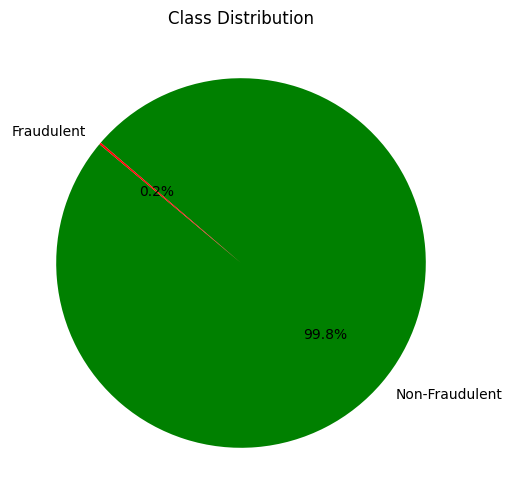

In [21]:
# Plot pie chart
fraud_count = credit_card_data['Class'].value_counts()
labels = ['Non-Fraudulent', 'Fraudulent']
plt.figure(figsize=(8, 6))
plt.pie(fraud_count, labels=labels, autopct='%1.1f%%', colors=['green', 'red'], startangle=140)
plt.title('Class Distribution')
plt.show()


Based on the count of fraudulent (1) vs. non-fraudulent (0) transactions. we have class imbalance  because in the case of fraud detection, fraudulent transactions (Class = 1) are much rarer compared to non-fraudulent transactions (Class = 0) This can cause machine learning models to perform poorly on the minority class (fraudulent transactions) because they are biased toward predicting the majority class So there isb the need for techniques like oversampling (SMOTE) or undersampling during model training.

## Correlation Matrix

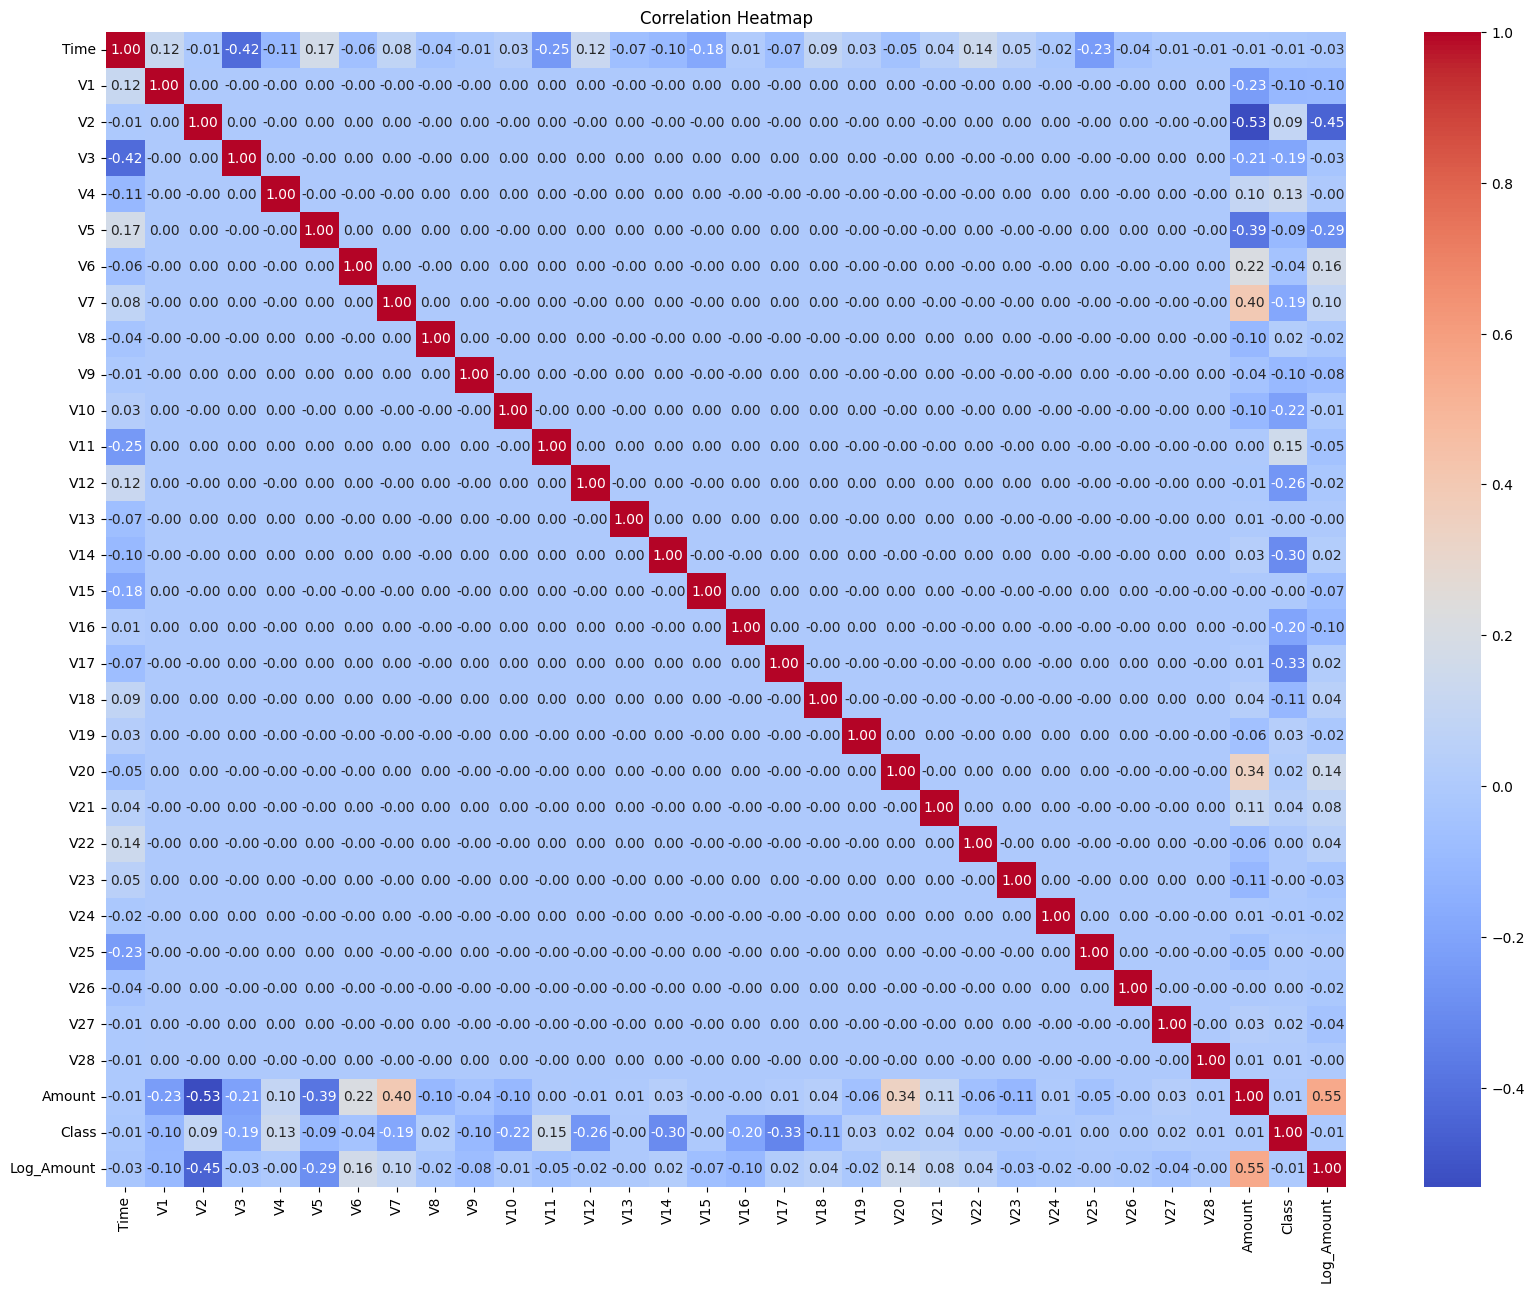

In [22]:
# Correlation matrix
corr_matrix = credit_card_data.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [23]:
#corr_matrix

Based on the correlation matrix, it seems there is no correlation between the features obtained after applying PCA because the values approach zero.
As the principle behind Principal Component Analysis (PCA) is to reduce the dimensionality of a dataset while retaining as much variability (or information) as possible. It does so by finding new uncorrelated variables that's wht the correlation is Zero in those variable means from V1 to V28. 
 Additionally, there is a moderate negative correlation between Amount and V2, with a value of -0.45 and between V7 and Amount, there is a moderate positive correlation with a value of 0.40.

After applying a log transformation to the Amount, the correlation of Amount with V1 and V7 decreases to -0.45 and 0.1, respectively.


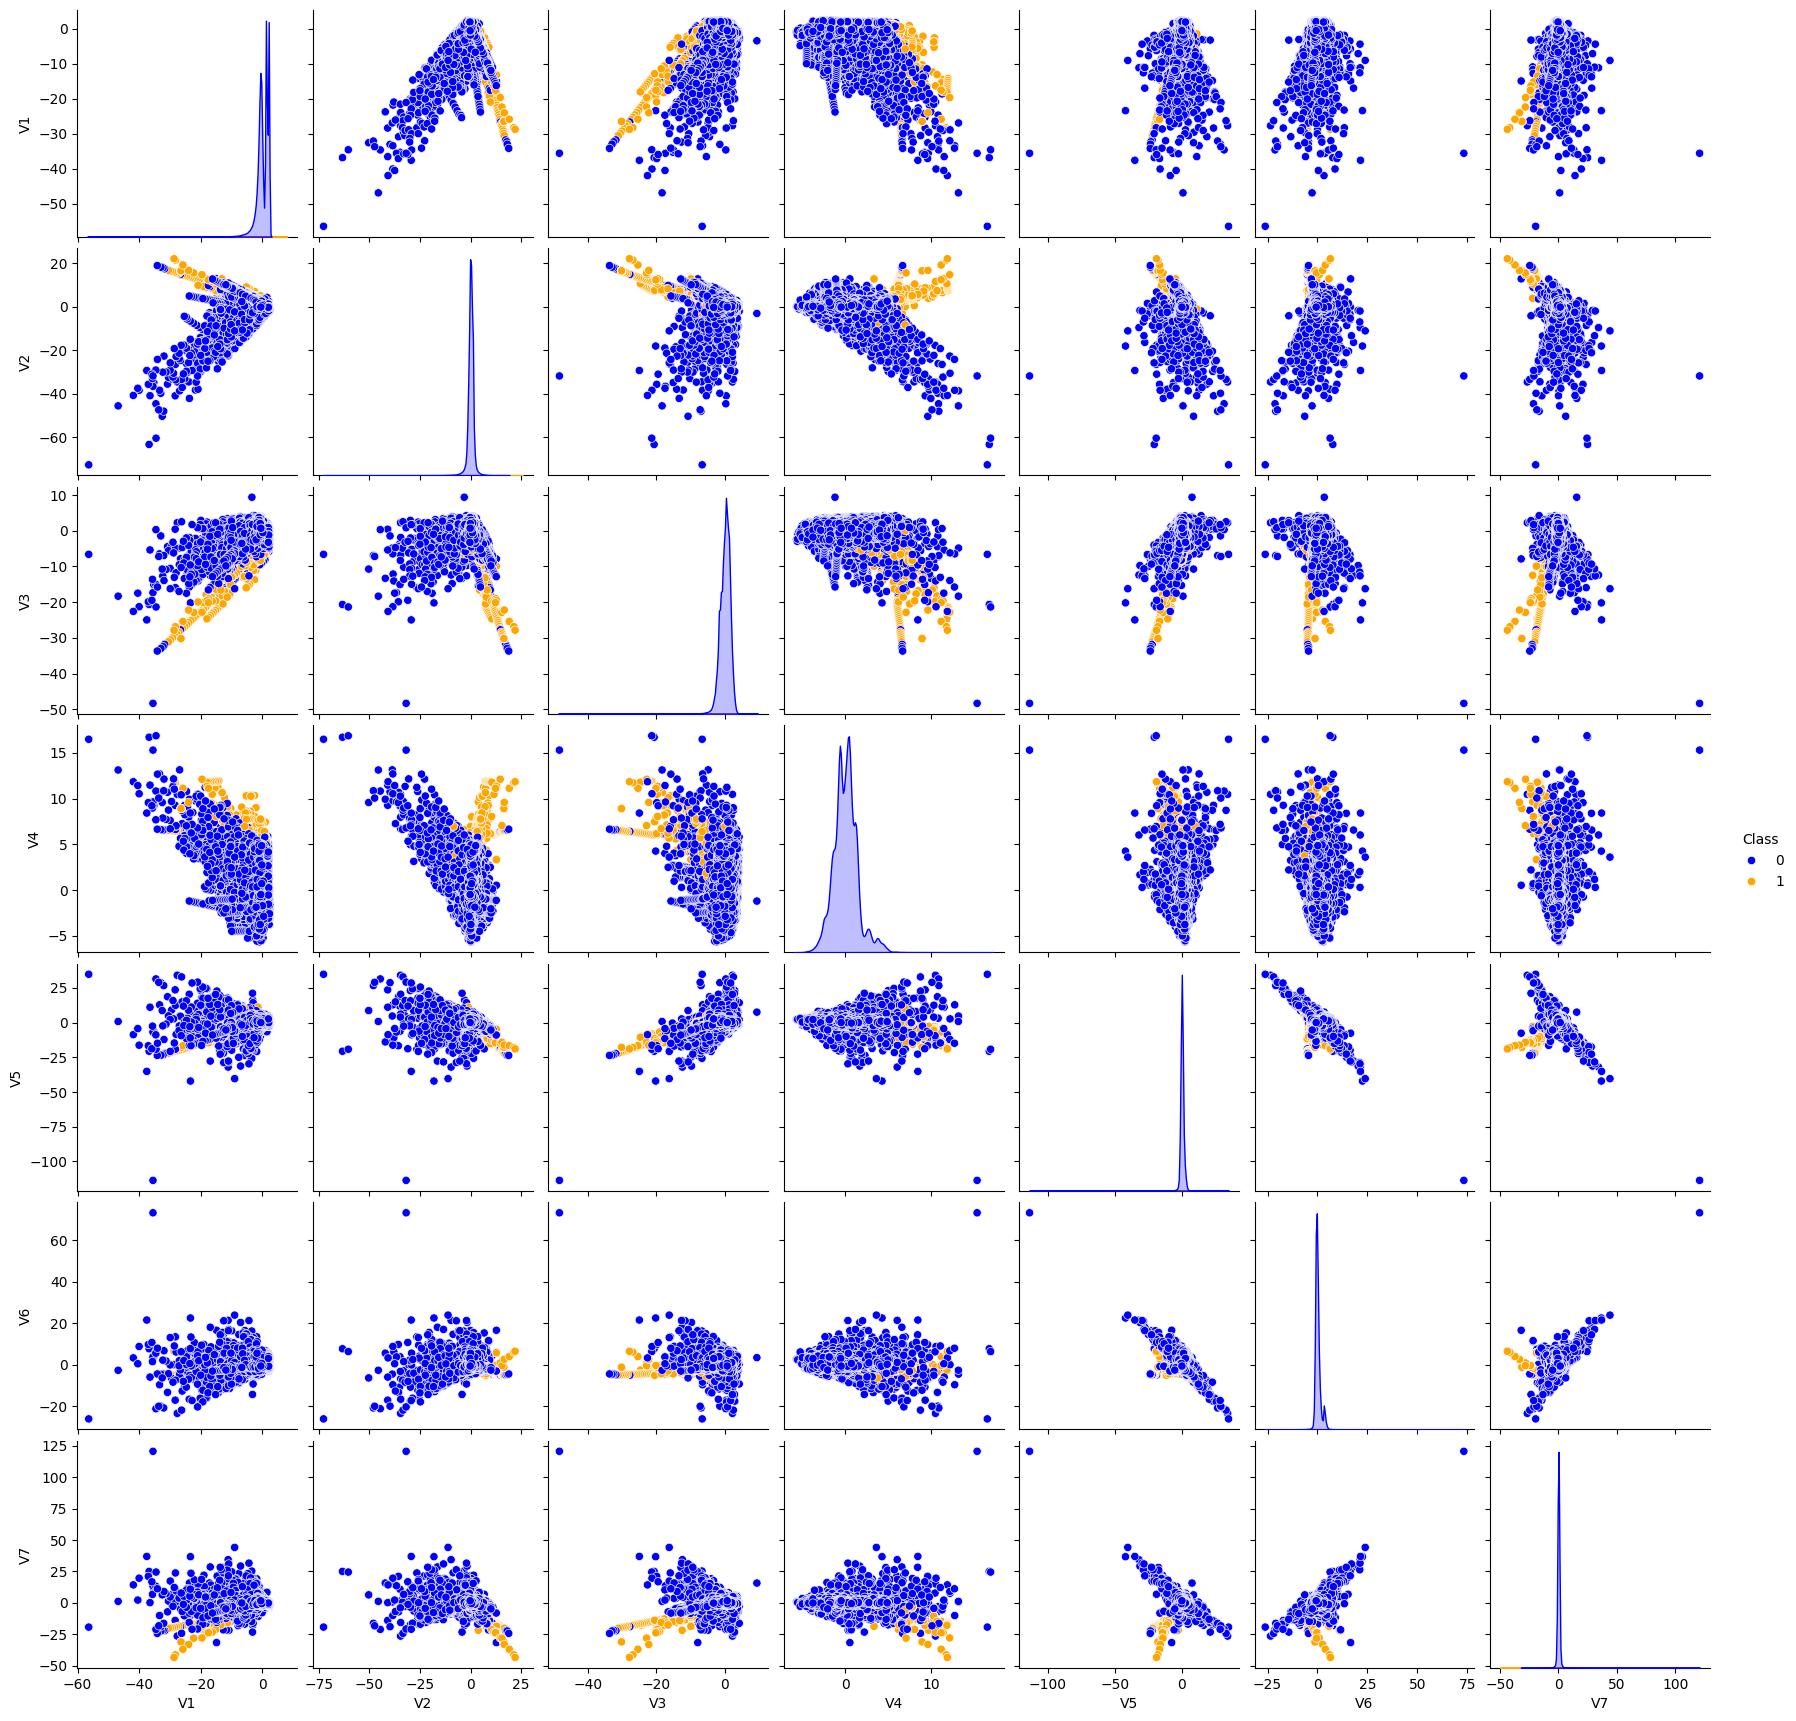

In [24]:
# Pairplot for selected features

sns.pairplot(credit_card_data[['V1', 'V2','V3', 'V4', 'V5','V6', 'V7','Class']], hue="Class", palette=["blue", "orange"])

plt.show()


Based on this pair plot we can see that we can use V4  and V2 to distinguish the fraudulent transaction and non-fraudulent transaction.

## Handle Data Imbalance

### 1. understand the Imbalance

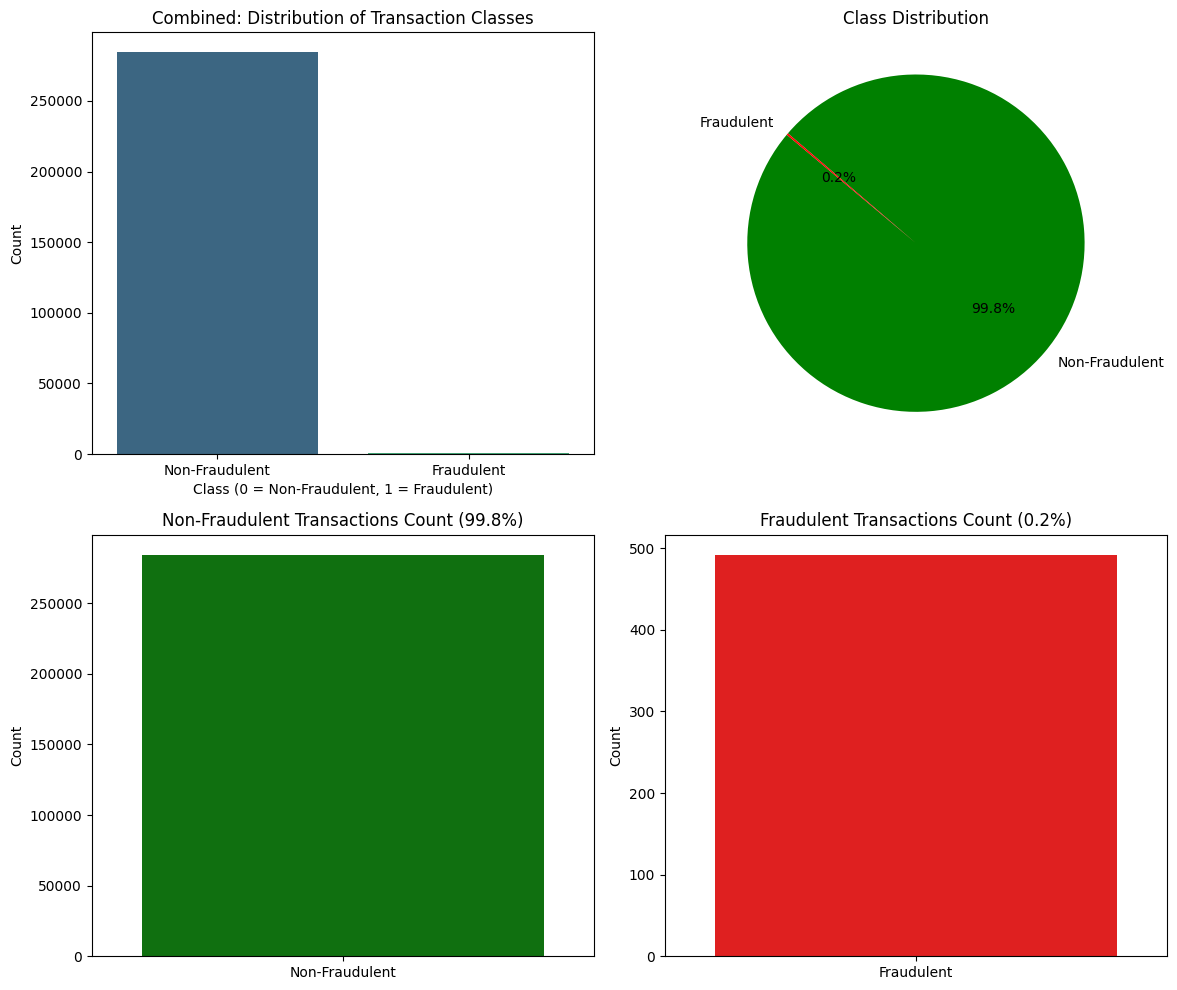

In [250]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Combined bar plot: Distribution of both classes (top-left)
sns.countplot(x='Class', data=credit_card_data, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Combined: Distribution of Transaction Classes')
axes[0, 0].set_xlabel('Class (0 = Non-Fraudulent, 1 = Fraudulent)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['Non-Fraudulent', 'Fraudulent'])

# Pie chart: Class distribution (top-right)
fraud_count = credit_card_data['Class'].value_counts()
labels = ['Non-Fraudulent', 'Fraudulent']
axes[0, 1].pie(
    fraud_count, labels=labels, autopct='%1.1f%%', 
    colors=['green', 'red'], startangle=140
)
axes[0, 1].set_title('Class Distribution')

# Separate bar plot: Non-Fraudulent transactions (bottom-left)
non_fraud_count = credit_card_data[credit_card_data['Class'] == 0].shape[0]
total_count = credit_card_data.shape[0]
non_fraud_percentage = (non_fraud_count / total_count) * 100
sns.barplot(
    x=['Non-Fraudulent'], 
    y=[non_fraud_count], 
    palette=['green'], ax=axes[1, 0]
)
axes[1, 0].set_title(f'Non-Fraudulent Transactions Count ({non_fraud_percentage:.1f}%)')
axes[1, 0].set_ylabel('Count')

# Separate bar plot: Fraudulent transactions (bottom-right)
fraudulent_count = credit_card_data[credit_card_data['Class'] == 1].shape[0]
fraud_percentage = (fraudulent_count / total_count) * 100
sns.barplot(
    x=['Fraudulent'], 
    y=[fraudulent_count], 
    palette=['red'], ax=axes[1, 1]
)
axes[1, 1].set_title(f'Fraudulent Transactions Count ({fraud_percentage:.1f}%)')
axes[1, 1].set_ylabel('Count')

# Adjust layout to fit all subplots
plt.tight_layout()
plt.show()


Nin fraudulent transaction heavily dominate the dataset,while fraudulent transaction are significant feuwer if you look on the first bar plot and if you look on the last two bar plot you can see that on the y-axis it shows clearly therange of Non-fraudulent transaction which range from 0.0 to 250000.0 whlile Fraudulent transaction range from 0.0 to 500.

The dataset has 99.8% "Non-Fraudulent" transactions while "Fraudulent" transaction have 0.2% , it indicates that most models might easily classify these correctly just by predicting "Non-Fraudulent" all the time. However, this would be ineffective for fraud detection.

In [253]:
x = credit_card_data.drop(columns = ['Class', 'Amount'] ,axis = 1)
y = credit_card_data['Class']
x.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log_Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.014760
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,1.305626
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.939276
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.824306
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.262539


### SMOTE 

We are using SMOTE to handle class imbalance in the dataset. It creates new synthetic data points for the minority class (Class 1) to balance the dataset by generating new fraudulent transaction samples based on the existing ones, rather than reducing the number of non-fraudulent samples."


# Model training

## 1. Logistic Regression


#### a. Training Logistic Model Before handling data imbalance using SMOTE

In [258]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns

def train(X, y):
    # Split the data into training and testing sets (80-20 split)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Initialize the Logistic Regression model
    model = LogisticRegression(random_state=42, class_weight="balanced", max_iter=1000)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    # Print the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Print ROC-AUC score
    print(f"ROC-AUC Score: {roc_auc:.2f}")
    
    # Plot the ROC curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Return metrics as a dictionary
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
    }
    
    return model, metrics, y_pred, y_pred_prob


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



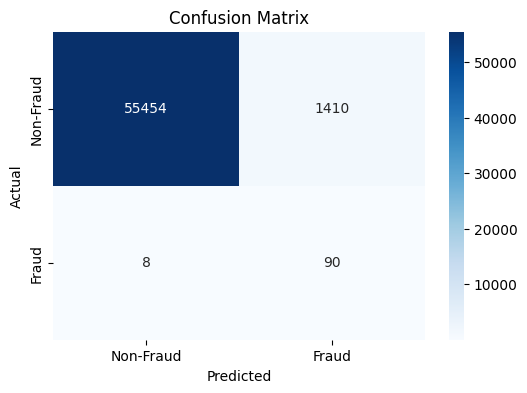

ROC-AUC Score: 0.97


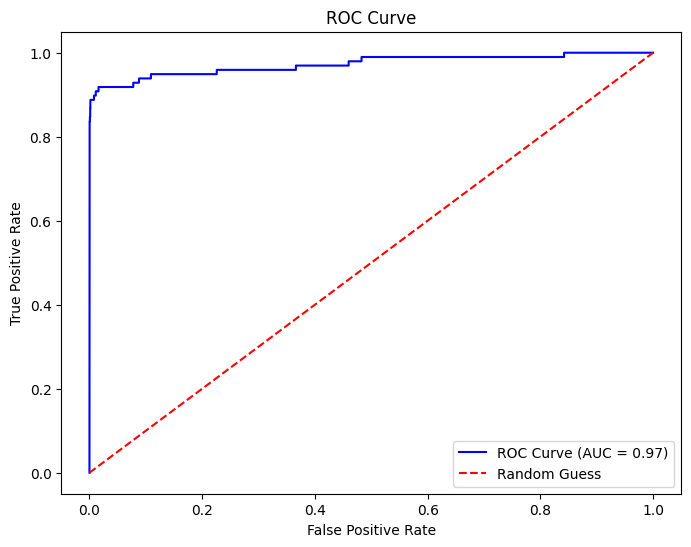

In [259]:
model = LogisticRegression()
model, metrics, y_pred, y_pred_prob = train(x,y)

In [260]:
from imblearn.over_sampling import SMOTE

# Separate features and target
X = credit_card_data.drop('Class', axis=1)
y = credit_card_data['Class']

# Calculate the ratio of original class distribution
original_class_count = y.value_counts()
non_fraud_count = original_class_count[0]
fraud_count = original_class_count[1]
ratio = non_fraud_count / fraud_count

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Print the ratio of the original distribution
print(f"\nOriginal Class Imbalance Ratio (Non-Fraudulent: Fraudulent): {ratio:.1f}:1")

print(f"Original Class Distribution(Before SMOTE):\n {y.value_counts()}")
print(f"Resampled Class Distribution(After SMOTE):\n {pd.Series(y_resampled).value_counts()}")



Original Class Imbalance Ratio (Non-Fraudulent: Fraudulent): 577.9:1
Original Class Distribution(Before SMOTE):
 Class
0    284315
1       492
Name: count, dtype: int64
Resampled Class Distribution(After SMOTE):
 Class
0    284315
1    284315
Name: count, dtype: int64


The dataset is highly imbalanced, with the majority class (Non-Fraudulent) dominating the minority class (Fraudulent) by a ratio of ~578:1. Such imbalance can cause machine learning models to perform poorly on the minority class, as they tend to favor the majority class.

SMOTE balances the dataset by synthesizing new fraudulent transactions (Class 1) based on the existing ones. The synthetic data points are interpolations and not exact duplicates, which helps prevent overfitting and the new class distribution is equal, with both classes containing 284,315 samples.

#### Display both the original and resampled class distributions (before and after applying SMOTE)

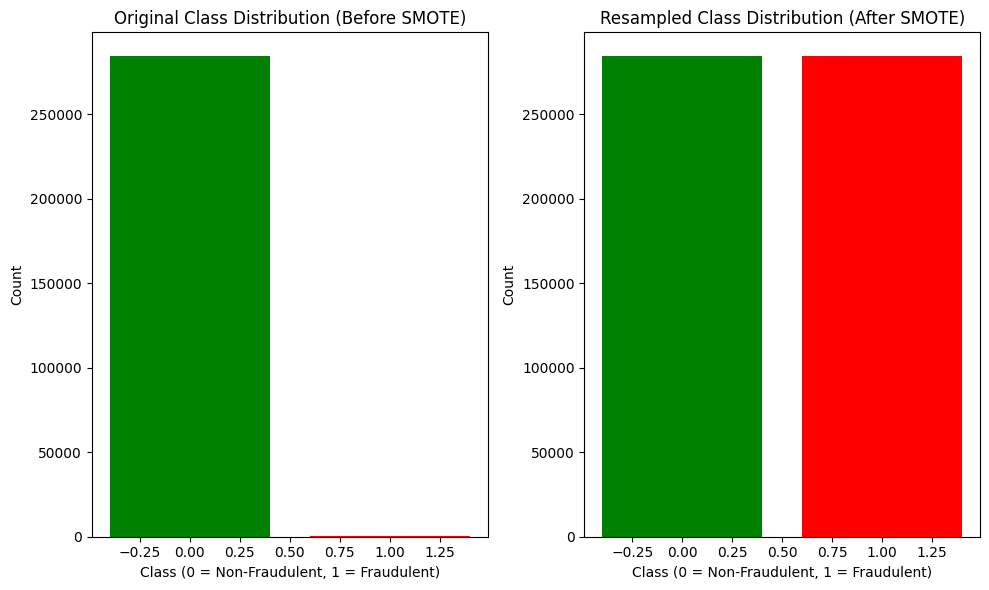

Original Class Distribution (Before SMOTE):
Class
0    284315
1       492
Name: count, dtype: int64
Resampled Class Distribution (After SMOTE):
Class
0    284315
1    284315
Name: count, dtype: int64


In [261]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Assuming credit_card_data is already loaded as a DataFrame
# Separate features and target
X = credit_card_data.drop('Class', axis=1)  # Features (excluding the target column 'Class')
y = credit_card_data['Class']  # Target variable

# Calculate original class distribution
original_class_count = y.value_counts()

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Calculate resampled class distribution
resampled_class_count = pd.Series(y_resampled).value_counts()

# Plot both the original and resampled class distributions
plt.figure(figsize=(10, 6))

# Plot original class distribution
plt.subplot(1, 2, 1)
plt.bar(original_class_count.index, original_class_count.values, color=['green', 'red'])
plt.title('Original Class Distribution (Before SMOTE)')
plt.xlabel('Class (0 = Non-Fraudulent, 1 = Fraudulent)')
plt.ylabel('Count')

# Plot resampled class distribution
plt.subplot(1, 2, 2)
plt.bar(resampled_class_count.index, resampled_class_count.values, color=['green', 'red'])
plt.title('Resampled Class Distribution (After SMOTE)')
plt.xlabel('Class (0 = Non-Fraudulent, 1 = Fraudulent)')
plt.ylabel('Count')

# Display the plot
plt.tight_layout()
plt.show()

# Print both the original and resampled class distributions
print(f"Original Class Distribution (Before SMOTE):\n{original_class_count}")
print(f"Resampled Class Distribution (After SMOTE):\n{resampled_class_count}")



#### b. Training Logistic Model After handling data imbalance by applying SMOTE


We are using Logistic regression  in classification tasks (predicting categories like 0(Non-fruderent) or 1(frauderent)). It predicts the probability that an instance belongs to a particular class using a logistic function (sigmoid curve). The output is a value between 0 and 1, which is thresholded to classify the data into categories.


In [262]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns

def train(X, y):
    # Split the data into training and testing sets (80-20 split)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Initialize the Logistic Regression model
    model = LogisticRegression(random_state=42, class_weight="balanced", max_iter=1000)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    # Print the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Print ROC-AUC score
    print(f"ROC-AUC Score: {roc_auc:.2f}")
    
    # Plot the ROC curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Return metrics as a dictionary
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
    }
    
    return model, metrics, y_pred, y_pred_prob


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



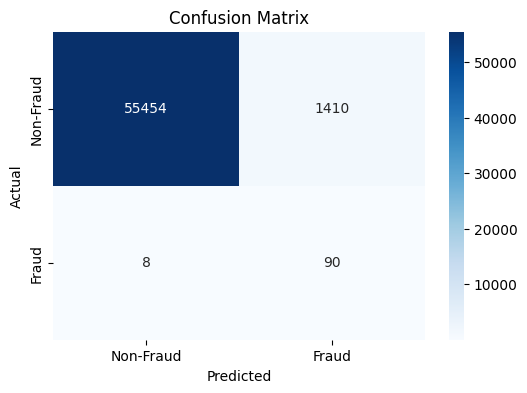

ROC-AUC Score: 0.97


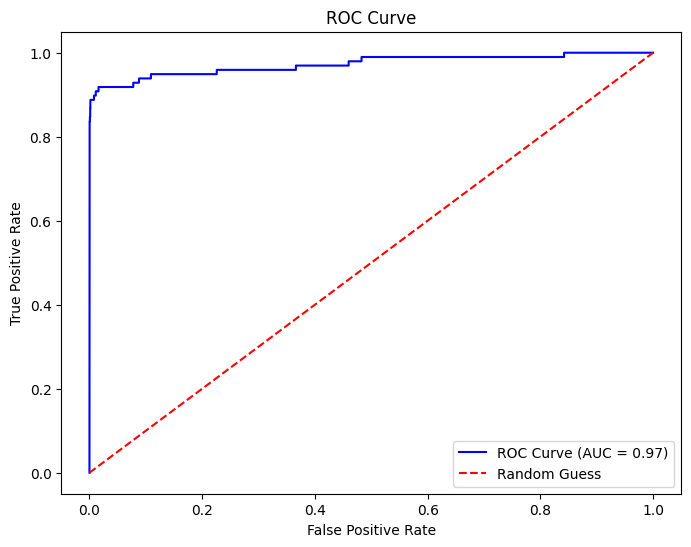

In [263]:
model, metrics, y_pred, y_pred_prob = train(x,y)

The value of ROC Curve(AUC = 0.97) shows that our model preditct fraudrent transaction well.

## 2. Random Forest

In [264]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import(
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

def train_random_forest(x,y):
    x_train, x_test, y_train, y_test = train_test_split(
        x,y,test_size=0.2, random_state = 42, stratify = y
    )

    model = RandomForestClassifier(
        random_state=42,
        class_weight = 'balanced',
        n_estimstors = 100,
        max_depth = None
    )  

    model.fit(x_train, y_train)



In [265]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

def train_random_forest(X, y):
    # Split the data into training and testing sets (80-20 split)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Initialize the Random Forest model
    model = RandomForestClassifier(
        random_state=42, 
        class_weight="balanced", 
        n_estimators=100, 
        max_depth=None
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    # Print the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Print ROC-AUC score
    print(f"ROC-AUC Score: {roc_auc:.2f}")
    
    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Return metrics as a dictionary
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
    }
    
    return model, metrics, y_pred, y_pred_prob


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962



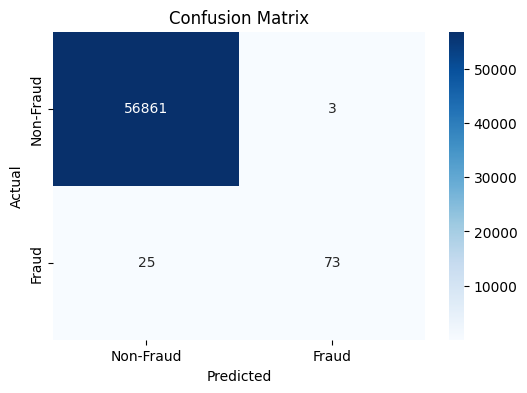

ROC-AUC Score: 0.95


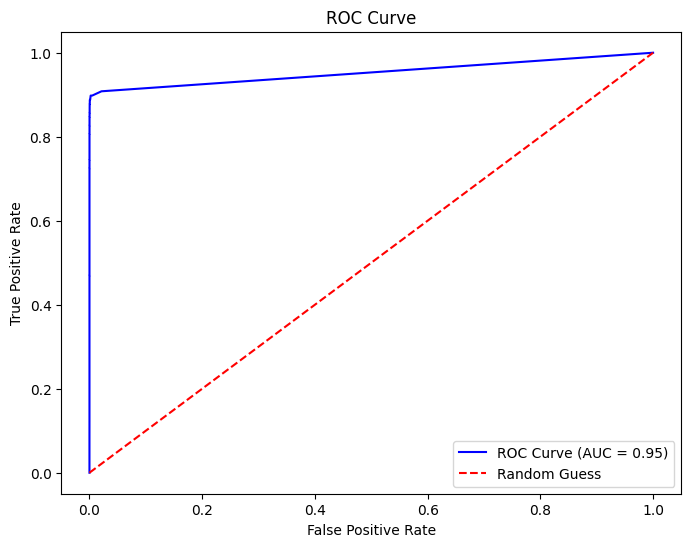

In [201]:
model= RandomForestClassifier()
model, metrics, y_pred, y_pred_prob = train_random_forest(x,y)